In [50]:
# LO CIRCUITS
# can always get a unitary matrix from a LO circuit in Perceval
# we can convert a matrix into a ZW circuit in optyx
# the opposite way is how we evaluate LO circuits in perceval

In [51]:
# MORE GENERAL CIRCUITS
#

In [106]:
import numpy as np

import perceval as pcvl
from perceval import catalog

In [107]:
p = pcvl.Processor("SLOS", 6)
p.add(0, catalog["postprocessed cnot"].build_processor())
p.add(0, pcvl.BS.H())
p.add(2, pcvl.Detector.pnr())
p.add(3, pcvl.Detector.pnr())
p.add(0, pcvl.Detector.pnr())
p.add(1, pcvl.Detector.pnr())

In [108]:
# 2 measured modes
# offset = 0 means that there is 0 empty modes between the measured modes and the circuit
# the default circuit is an empty circuit
ff_X = pcvl.FFCircuitProvider(2, 0, pcvl.Circuit(2))

# Now if we measure a logical state |1>, we need to perform a permutation of the modes
ff_X.add_configuration([0, 1], pcvl.PERM([1, 0]))

p.add(2, ff_X);

In [109]:
phi = pcvl.P("phi")
# Like Circuits and Processors, we can chain the `add` methods
ff_Z = pcvl.FFConfigurator(2, 3, pcvl.PS(phi), {"phi": 0}).add_configuration([0, 1], {"phi": np.pi})

#p.add(0, ff_Z);

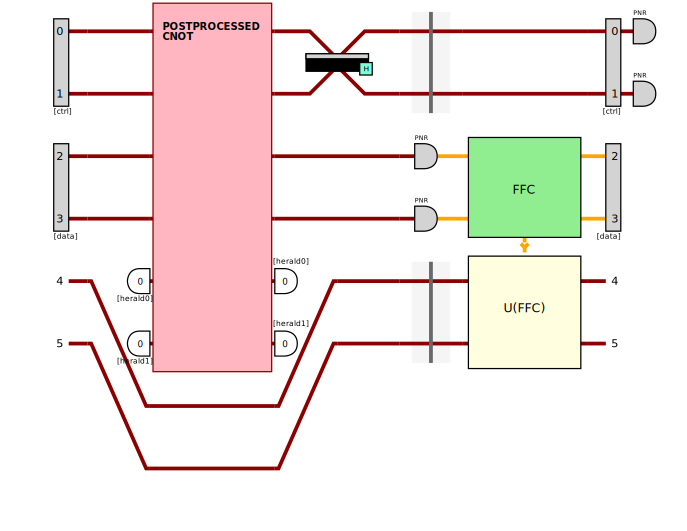

In [110]:
pcvl.pdisplay(p)

In [111]:
p.components

[[[4, 5, 6, 7],
 [[0, 1, 2, 3, 4, 5],
 [[4, 5, 6, 7],
 ((0, 1), <perceval.components.unitary_components.BS at 0x79566c461d80>),
 ((0, 1, 2, 3, 4, 5),
  <perceval.components.unitary_components.Barrier at 0x79566c3af040>),
 ((0, 1), <perceval.components.unitary_components.Barrier at 0x79566c3ae2c0>),
 ((2,), <perceval.components.detector.Detector at 0x79566c9642b0>),
 ((3,), <perceval.components.detector.Detector at 0x79566c4409a0>),
 ((4, 5), <perceval.components.unitary_components.Barrier at 0x79566c3aec80>),
 ((2, 3),
  <perceval.components.feed_forward_configurator.FFCircuitProvider at 0x79566c3aef80>)]

In [112]:
np.array(p.components[9][1].default_circuit.U, dtype=np.complex128)

array([[1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j]])

In [113]:
from optyx import photonic

In [114]:
from optyx.classical import SubN, Digit

(Digit(2) @ Digit(6) >> SubN()).eval()

EvalResult(_tensor=tensor.Box[complex128]('Result', Dim(1), Dim(3), data=array([0.+0.j, 0.+0.j, 0.+0.j])), output_types=optyx.core.channel.Ty(optyx.core.channel.Ob('mode')), state_type=<StateType.DM: 'dm'>)

In [115]:
c

((2, 3),
 <perceval.components.feed_forward_configurator.FFCircuitProvider at 0x79566c81ceb0>)

In [116]:
from optyx._utils import matrix_to_zw
from optyx import Channel, mode, qmode, photonic, bit
from optyx.classical import ClassicalFunction, BitControlledGate
from perceval.components.detector import DetectionType
from optyx.core.channel import Spider, Diagram

n_modes = p.circuit_size
circuit = photonic.Id(n_modes)
for c in p.components:
    component = c[1]
    wires = c[0]
    left = circuit.cod[:min(wires)]
    right = circuit.cod[max(wires)+1:]
    if isinstance(component, pcvl.Detector):
        if component.type == DetectionType.PNR:
            circuit_component = photonic.NumberResolvingMeasurement(len(wires))
        elif component.type == DetectionType.Threshold:
            circuit_component = photonic.PhotonThresholdMeasurement(len(wires))
        else:
            raise ValueError(f"Unsupported perceval detector type: {c.type}")
        box = circuit_component
    elif isinstance(component, pcvl.components.feed_forward_configurator.FFCircuitProvider):
        default_action = matrix_to_zw(
            np.array(
                component.default_circuit.U,
                dtype=np.complex128
            )
        )

        n_classical_wires = len(list(component._map.keys())[0])
        n_action_wires = len(default_action.dom)
        n_offset = np.abs(component._offset)

        if component._offset < 0:
            p_input = (
                list(range(n_action_wires + n_offset, n_action_wires + n_offset + n_classical_wires)) +
                list(range(0, n_action_wires)) +
                list(range(n_action_wires, n_action_wires + n_offset))
            )
            input_permutation = Diagram.permutation(
                p_input,
                qmode**(n_action_wires + n_offset) @ mode**n_classical_wires
            )

            left = circuit.cod[:min(wires)]
            right = circuit.cod[max(wires)+1:]

            left = circuit.cod[:min(wires)]
            right = circuit.cod[max(wires) + n_offset + n_action_wires + 1:]

        else:
            p_input = (
                list(range(n_classical_wires, n_classical_wires + n_offset)) +
                list(range(0, n_classical_wires)) +
                list(range(n_classical_wires + n_offset, n_classical_wires + n_offset + n_action_wires))
            )
            input_permutation = Diagram.permutation(
                p_input,
                mode**n_classical_wires @ qmode**(n_action_wires + n_offset)
            )

            left = circuit.cod[:min(wires)]
            right = circuit.cod[max(wires) + n_offset + n_action_wires + 1:]

        for i, (state, action_circuit) in enumerate(component._map.items()):
            if i==0:
                box = mode**len(state) @ photonic.Id(len(default_action.dom))
            if not i == len(component._map) - 1:
                copy = Spider(1, 2, mode)**len(state)
                permutation = Diagram.permutation(
                    list(range(0, len(state)*2, 2)) + list(range(1, len(state)*2, 2)),
                    mode**(2*len(state))
                )
                copied_wires = Diagram.id(mode**len(state))
            else:
                copy = Diagram.id(mode**len(state))
                permutation = Diagram.id(mode**len(state))
                copied_wires = Diagram.id(mode**0)
            def f(x):
                if all(s == a for s, a in zip(list(state), x)):
                    return [1]
                else:
                    return [0]
            func = ClassicalFunction(f, mode**len(state), bit)
            action = matrix_to_zw(
                np.array(
                    action_circuit.U,
                    dtype=np.complex128
                )
            )
            ctrl_box = BitControlledGate(
                action,
                default_action
            )

            q_wires = qmode**len(default_action.dom)

            box >>= (
                copy @ q_wires >>
                permutation @ q_wires >>
                copied_wires @ func @ q_wires >>
                copied_wires @ ctrl_box

            )
        box = (
            input_permutation >>
            box
        )


        # need a wire permutation to get the classical measurement output
        # to the right place in the circuit (next to the actioned modes)

        # you can chain each configuration
        # copy the classical data for each config (using a spider)
        # and use it for the next config

        # need to find a way to get a specific multi mode configuration to a simple 1/0
            # classical function? n->1 if the state is as in the configuration, 0 otherwise
    elif hasattr(component, 'U'):
        circuit_component = matrix_to_zw(np.array(component.U, dtype=np.complex128))
        box = Channel(
            name=c[1].name,
            kraus=circuit_component
        )
    else:
        raise ValueError(f"Unsupported perceval component type: {type(component)}")
    circuit_layer = left @ box @ right
    circuit >>= circuit_layer

AxiomError: qmode @ qmode @ mode @ mode @ I @ qmode @ qmode does not compose with qmode @ qmode @ F @ qmode @ qmode @ qmode @ qmode @ qmode @ qmode: qmode @ qmode @ mode @ mode @ qmode @ qmode @ qmode @ qmode != qmode @ qmode @ mode @ mode @ qmode @ qmode @ qmode @ qmode @ qmode @ qmode.

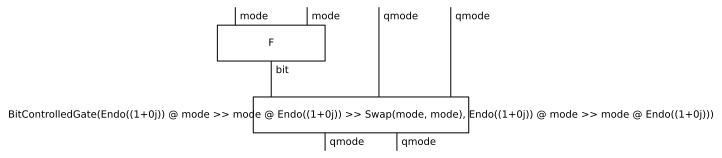

In [117]:
box.draw()

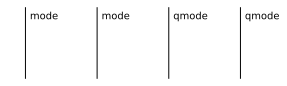

In [118]:
input_output_permutation.draw()

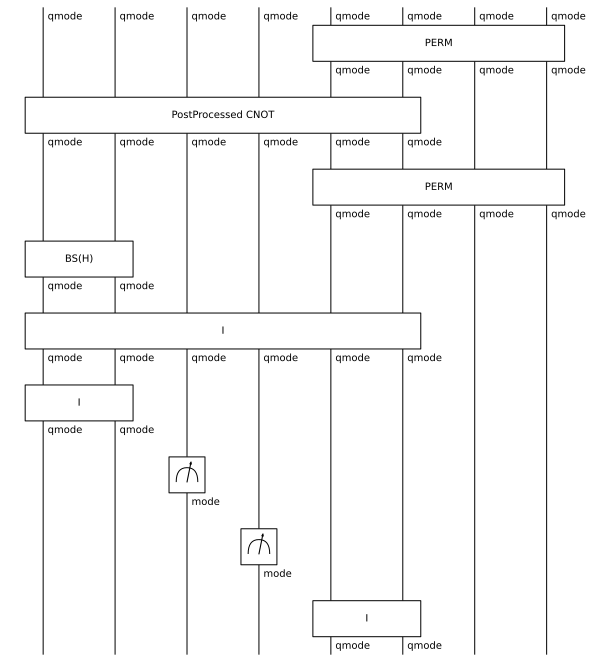

In [120]:
circuit.draw()

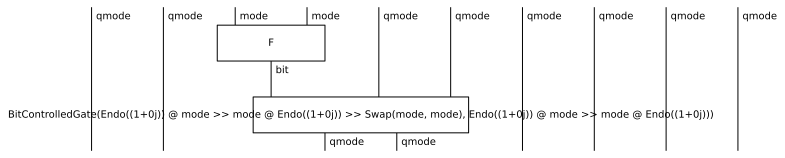

In [121]:
circuit_layer.draw()

In [10]:
from optyx.core.channel import Diagram, qmode, mode

In [15]:
l = 6
permutation = Diagram.permutation(
    list(range(0, l*2, 2)) + list(range(1, l*2, 2)),
    mode**(2*l)
)

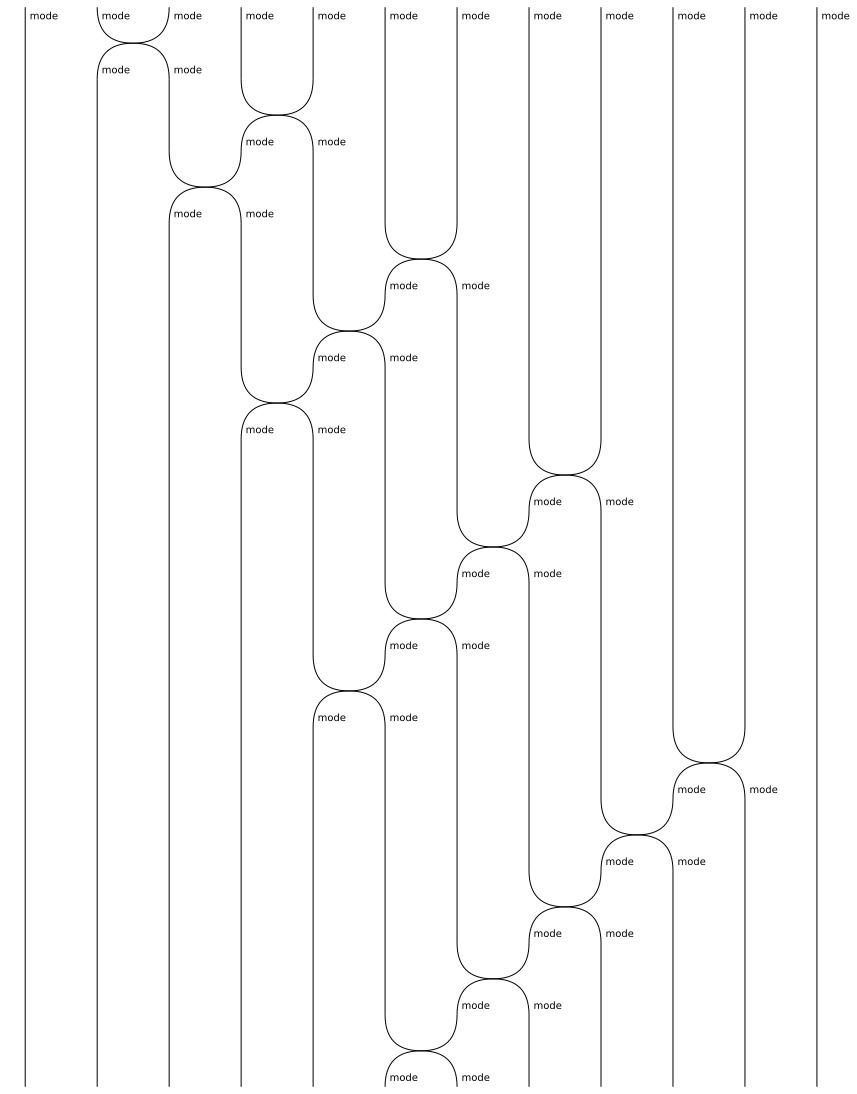

In [16]:
permutation.draw()

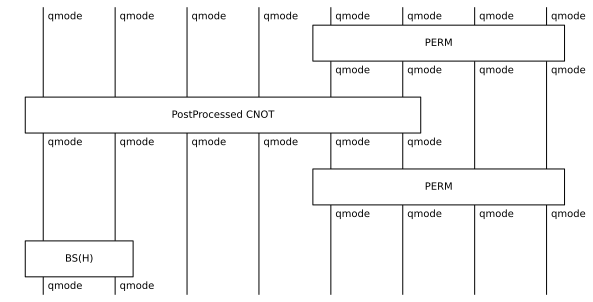

In [58]:
circuit.draw()

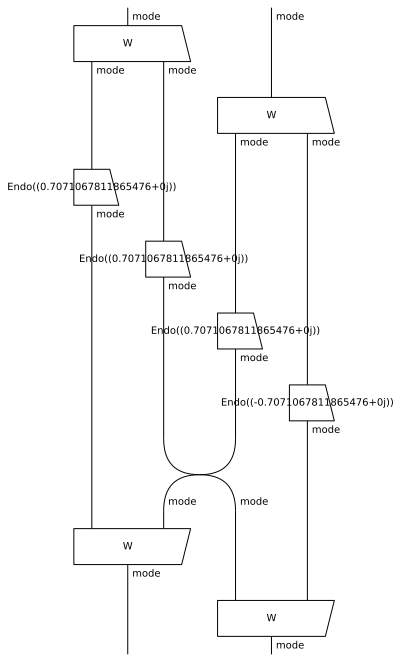

In [51]:
circuit_kraus.draw()

In [31]:
np.array(c[1].U, dtype=np.complex128)

array([[ 0.57735027+0.j,  0.        +0.j,  0.        +0.j,
         0.        +0.j,  0.81649658+0.j,  0.        +0.j],
       [ 0.        +0.j, -0.57735027+0.j,  0.57735027+0.j,
         0.57735027+0.j,  0.        +0.j,  0.        +0.j],
       [ 0.        +0.j,  0.57735027+0.j,  0.57735027+0.j,
         0.        +0.j,  0.        +0.j,  0.57735027+0.j],
       [ 0.        +0.j,  0.57735027+0.j,  0.        +0.j,
         0.57735027+0.j,  0.        +0.j, -0.57735027+0.j],
       [ 0.81649658+0.j,  0.        +0.j,  0.        +0.j,
         0.        +0.j, -0.57735027+0.j,  0.        +0.j],
       [ 0.        +0.j,  0.        +0.j,  0.57735027+0.j,
        -0.57735027+0.j,  0.        +0.j, -0.57735027+0.j]])

In [28]:
np.array(c[1].U)

array([[0.577350269189626, 0, 0, 0, 0.816496580927726, 0],
       [0, -0.577350269189626, 0.577350269189626, 0.577350269189626, 0,
        0],
       [0, 0.577350269189626, 0.577350269189626, 0, 0, 0.577350269189626],
       [0, 0.577350269189626, 0, 0.577350269189626, 0,
        -0.577350269189626],
       [0.816496580927726, 0, 0, 0, -0.577350269189626, 0],
       [0, 0, 0.577350269189626, -0.577350269189626, 0,
        -0.577350269189626]], dtype=object)

In [9]:
p.components[0]

[[4, 5, 6, 7], <perceval.components.unitary_components.PERM at 0x71ae703c2e90>]

In [12]:
np.array(p.components[0][1].U)

array([[0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
       [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j]])

In [15]:
p.components[0][1].name

'PERM'

In [43]:
from optyx._utils import matrix_to_zw
from optyx import Channel, mode, qmode, photonic, bit
from optyx.classical import ClassicalFunction, BitControlledGate
from perceval.components.detector import DetectionType
from optyx.core.channel import Spider, Diagram

ff_X = pcvl.FFCircuitProvider(2, 0, pcvl.Circuit(2))

# Now if we measure a logical state |1>, we need to perform a permutation of the modes
ff_X.add_configuration([0, 1], pcvl.PERM([1, 0]))
ff_X.add_configuration([5, 4], pcvl.PERM([1, 0]))
ff_X.add_configuration([3, 1], pcvl.PERM([1, 0]))

component = ff_X

default_action = matrix_to_zw(
    np.array(
        component.default_circuit.U,
        dtype=np.complex128
    )
)

for i, (state, action_circuit) in enumerate(component._map.items()):
    if i==0:
        box = mode**len(state) @ photonic.Id(len(default_action.dom))
    if not i == len(component._map) - 1:
        copy = Spider(1, 2, mode)**len(state)
        permutation = Diagram.permutation(
            list(range(0, len(state)*2, 2)) + list(range(1, len(state)*2, 2)),
            mode**(2*len(state))
        )
        copied_wires = Diagram.id(mode**len(state))
    else:
        copy = Diagram.id(mode**len(state))
        permutation = Diagram.id(mode**len(state))
        copied_wires = Diagram.id(mode**0)
    def f(x):
        if all(s == a for s, a in zip(list(state), x)):
            return [1]
        else:
            return [0]
    func = ClassicalFunction(f, mode**len(state), bit)
    action = matrix_to_zw(
        np.array(
            action_circuit.U,
            dtype=np.complex128
        )
    )
    ctrl_box = BitControlledGate(
        action,
        default_action
    )

    q_wires = qmode**len(default_action.dom)

    box >>= (
        copy @ q_wires >>
        permutation @ q_wires >>
        copied_wires @ func @ q_wires >>
        copied_wires @ ctrl_box

    )

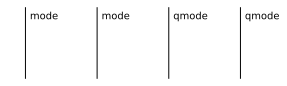

In [44]:
(copy @ q_wires).draw()

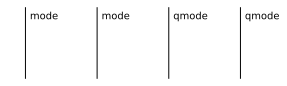

In [45]:
(permutation @ q_wires).draw()

In [46]:
# each component has a matrix, therefore can be easily converted to a ZW circuit

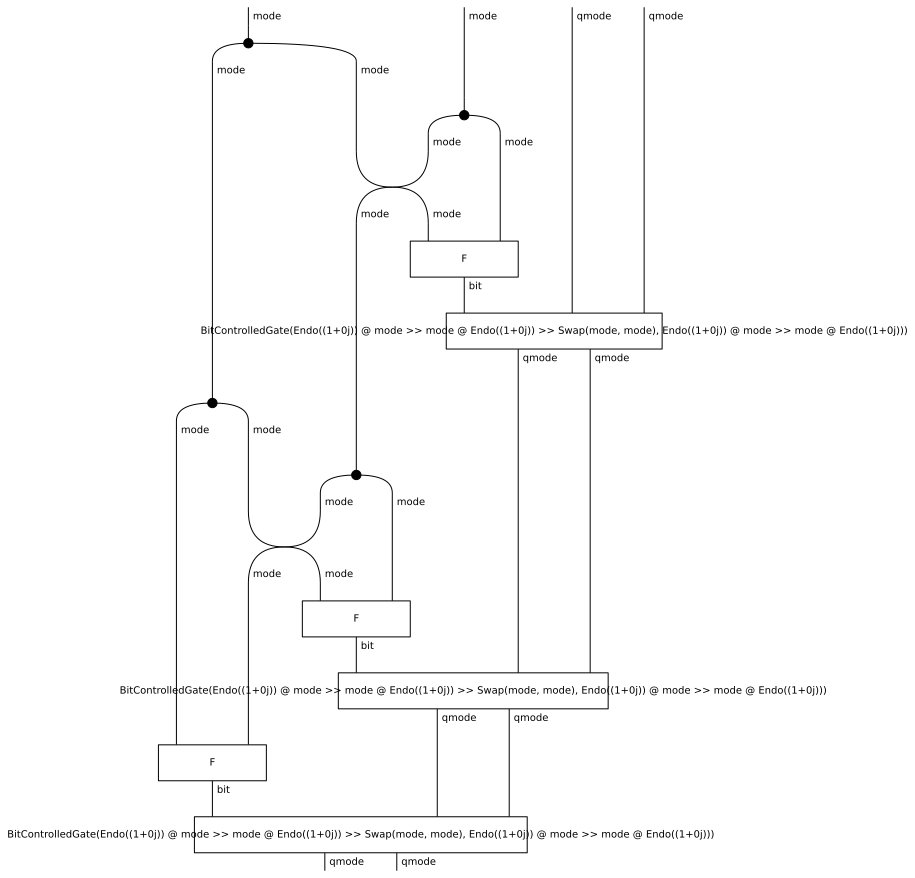

In [47]:
box.draw()

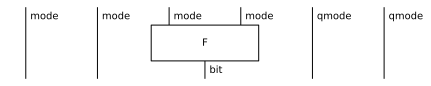

In [48]:
(mode**len(state) @ func @ q_wires).draw()

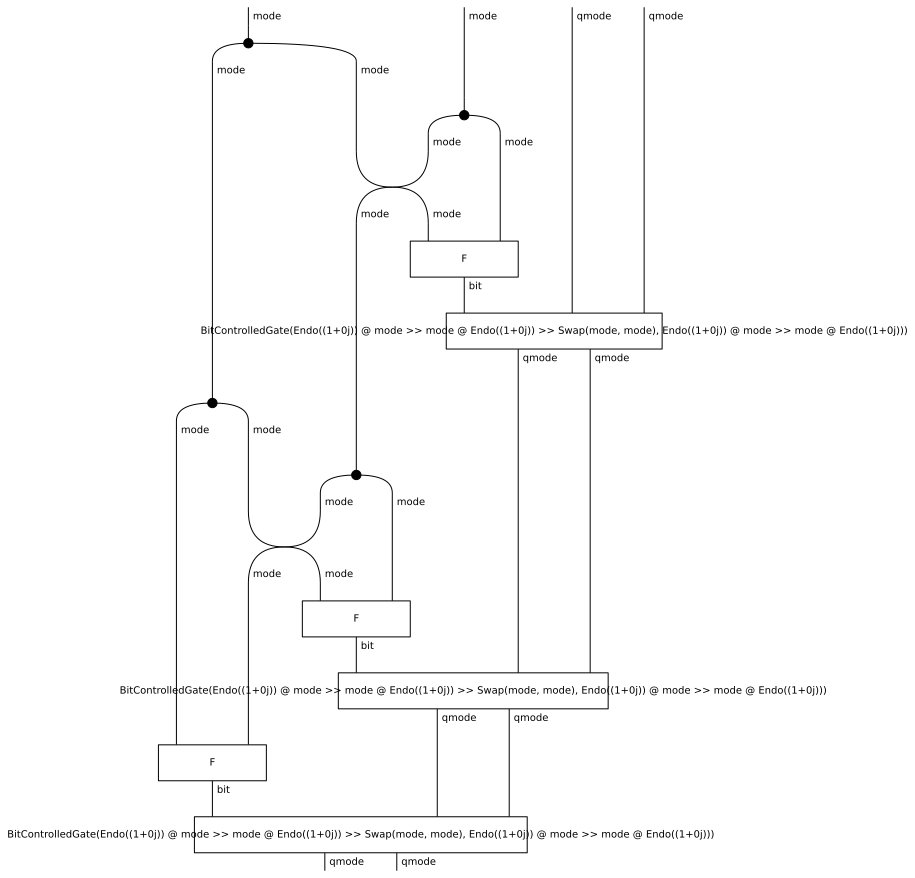

In [49]:
box.draw()

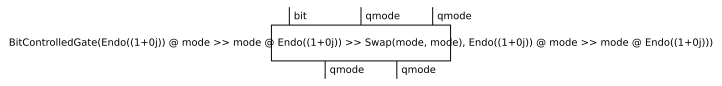

In [36]:
(copied_wires @ ctrl_box).draw()